# Capstone Project

###### This notebook will be mainly used for the capstone project

### Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


!conda install -c conda-forge geopy

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


### Get Data

In [2]:
# New York
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
    
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


In [3]:
# Toronto
from bs4 import BeautifulSoup
toronto = BeautifulSoup(requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', timeout=5).content, 'html.parser')

columns=['Postcode', 'Borough', 'Neighbourhood']
post_table = toronto.find('table')
post_row = post_table.findAll('tr')
db_toronto = pd.DataFrame(columns=columns)

for idx, val in enumerate(post_row):
    post_cell = val.findAll('td')
    df = []
    for idx, val in enumerate(post_cell):
        df.append(val.text.rstrip())
    if(int(len(df)) > 0):
        if(df[1] != "Not assigned"):
            if(df[2] == "Not assigned"):
                df[2] = df[1]

            df_dic={columns[0]: df[0], columns[1]: df[1], columns[2]: df[2]}
            db_toronto = db_toronto.append(df_dic, ignore_index=True)

db_toronto = db_toronto.groupby('Postcode', as_index=False).agg(lambda x: ', '.join(set(x.dropna())))

!wget -O geo_data.csv https://cocl.us/Geospatial_data
db_geo = pd.read_csv("geo_data.csv")
db_toronto = db_toronto.join(db_geo)
db_toronto = db_toronto.drop(db_toronto.columns[3], axis=1)

--2020-02-17 05:51:43--  https://cocl.us/Geospatial_data
Resolving cocl.us (cocl.us)... 158.85.108.83, 169.48.113.194, 158.85.108.86
Connecting to cocl.us (cocl.us)|158.85.108.83|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-02-17 05:51:45--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 107.152.26.197, 107.152.27.197
Connecting to ibm.box.com (ibm.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-02-17 05:51:46--  https://ibm.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/9afzr83pps4pwf2sm

### Connect to FourSquare

In [4]:
# The code was removed by Watson Studio for sharing.

### Get Venues for both cities

In [5]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [6]:
# New York Venues
ny_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                  latitudes=neighborhoods['Latitude'],
                                  longitudes=neighborhoods['Longitude'])

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [9]:
# Toronto Venues
db_toronto.rename(columns = {'Neighbourhood':'Neighborhood'}, inplace = True) 
tor_venues = getNearbyVenues(names=db_toronto['Neighborhood'],
                                  latitudes=db_toronto['Latitude'],
                                  longitudes=db_toronto['Longitude'])

Rouge, Malvern
Port Union, Highland Creek, Rouge Hill
Guildwood, West Hill, Morningside
Woburn
Cedarbrae
Scarborough Village
Ionview, East Birchmount Park, Kennedy Park
Oakridge, Clairlea, Golden Mile
Cliffside, Scarborough Village West, Cliffcrest
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Maryvale, Wexford
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Steeles East, Milliken, Agincourt North, L'Amoreaux East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Willowdale, Newtonbrook
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Downsview North, Bathurst Manor, Wilson Heights
York University, Northwood Park
Downsview East, CFB Toronto
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

### Compare Venues between Cities

In [ ]:
#ny_venues
#ny_venues[unique'Venue Category']

# ny_venues.unique(ny_venues[['Venue Category']].values.ravel('K'))
# array(['Bob', 'Joe', 'Bill', 'Mary', 'Steve'], dtype=object)

ny_count = ny_venues['Venue Category'].value_counts()
tor_count = tor_venues['Venue Category'].value_counts()
ny_count = ny_count.sort_index(ascending=True)
#venues = ny_count.join(tor_count)
# ny_count.index.name = 'Venue'
# ny_count.reset_index('Venue', inplace=True)
# ny_count.reset_index()



# ny_venues2 = ny_venues
# ny_count2 = ny_venues['Venue Category'].value_counts 

# ny_count2 = ny_count2.to_dict() #converts to dictionary

# ny_venues2['Count_Column'] = ny_venues['Venue Category'].map(ny_count2) 
# ny_venues2

#ny_count
df = pd.DataFrame(ny_count).transpose()

df.append(dict(zip(df.columns, [col[1] for col in df])), ignore_index=True)
df



#Tronto 
ny_count.rename({"Venue Category": "New York"}, axis='index')
tor_count = tor_count.sort_index(ascending=True)

df2 = pd.DataFrame(tor_count).transpose()

df2.append(dict(zip(df2.columns, [col[1] for col in df2])), ignore_index=True)
df2

Text(0.5, 1.0, 'Top 10 Venues in New York')

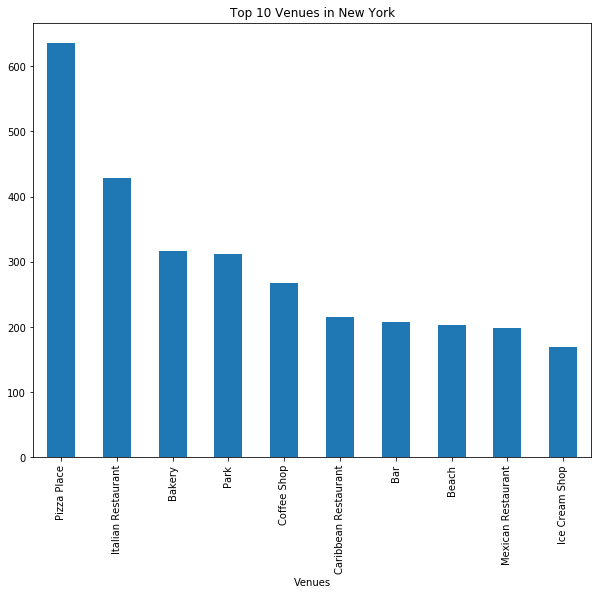

In [94]:
plt.figure(figsize=(10,8))
ny_venues['Venue Category'].value_counts().nlargest(10).plot(kind='bar')
plt.xlabel('Venues')
plt.title('Top 10 Venues in New York')

Text(0.5, 1.0, 'Top 10 Venues in Toronto')

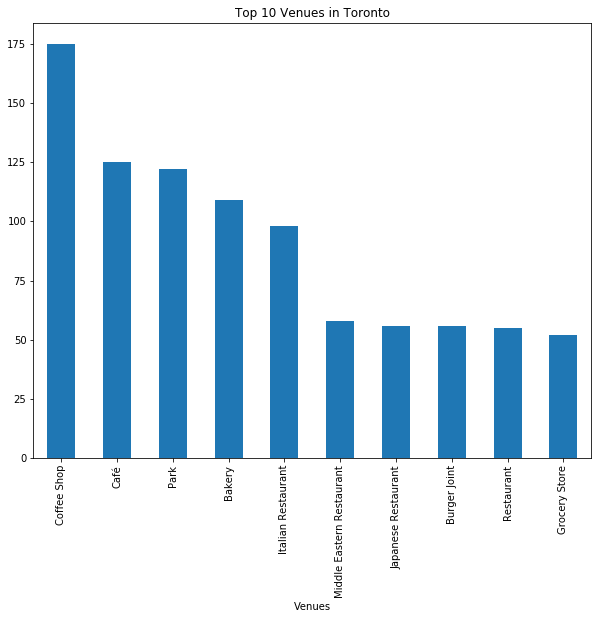

In [91]:
plt.figure(figsize=(10,8))
tor_venues['Venue Category'].value_counts().nlargest(10).plot(kind='bar')
plt.xlabel('Venues')
plt.title('Top 10 Venues in Toronto')